# KANs Example Revisited

Source: https://github.com/KindXiaoming/pykan/blob/master/docs/Examples/Example_3_classfication.ipynb

## "KANs can't beat GAM in performance, explainability and robustness."

In [ ]:
!pip install piml
!pip install pykan

In [ ]:
from piml import Experiment
exp = Experiment(highcode_only=True)

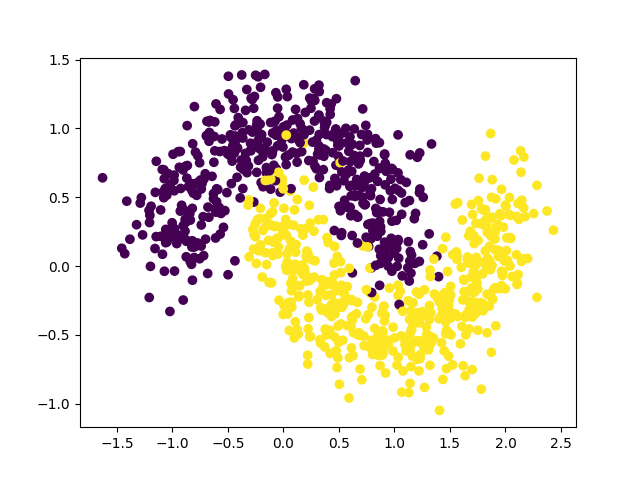

In [2]:
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.2, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.2, random_state=None)

dataset['train_input'] = torch.from_numpy(train_input)
dataset['test_input'] = torch.from_numpy(test_input)
dataset['train_label'] = torch.from_numpy(train_label[:,None])
dataset['test_label'] = torch.from_numpy(test_label[:,None])

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0], X[:,1], c=y[:,0])

# One-layer KAN

In [3]:
model = KAN(width=[2,1], grid=3, k=3)

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())

results = model.train(dataset, opt="LBFGS", steps=10,
                      metrics=(train_acc, test_acc),
                      in_vars=[r'$x_1$', r'$x_2$'],
                      save_fig=True, img_folder="img_OneLayer")
results['train_acc'][-1], results['test_acc'][-1]

train loss: 2.42e-01 | test loss: 2.51e-01 | reg: 2.89e+00 : 100%|██| 10/10 [00:18<00:00,  1.88s/it]


(0.9620000123977661, 0.9570000171661377)

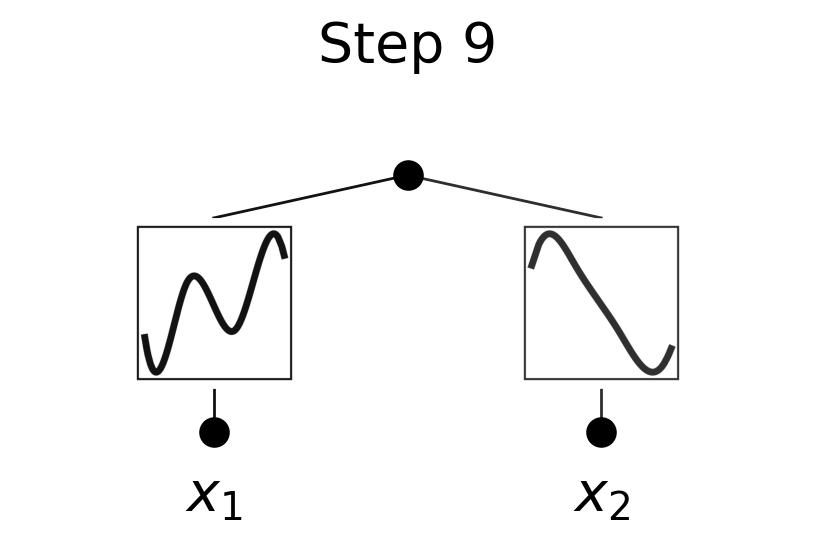

In [4]:
from IPython.display import Image

Image(filename='/content/img_OneLayer/9.jpg', height=300)

In [5]:
def predict_proba_func(X):
    proba = np.clip(model(torch.from_numpy(X))[:,0].detach().numpy(), 0, 1)
    return np.vstack([1 - proba, proba]).T

def predict_func(X):
    proba = np.clip(model(torch.from_numpy(X))[:,0].detach().numpy(), 0, 1) > 0.5
    return proba

pipeline = exp.make_pipeline(predict_func=predict_func,
                             predict_proba_func=predict_proba_func,
                             task_type="classification",
                             train_x=train_input,
                             train_y=train_label,
                             test_x=test_input,
                             test_y=test_label,
                             feature_names=["x1", "x2"],
                             target_name="y")
exp.register(pipeline, "KAN_OneLayer")

In [6]:
exp.model_diagnose(model="KAN_OneLayer", show="accuracy_table")

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.9630,0.9932,0.9627,0.1924,0.0500
Test,0.9600,0.9928,0.9597,0.1974,0.0520
Gap,-0.0030,-0.0004,-0.0030,0.0049,0.0020


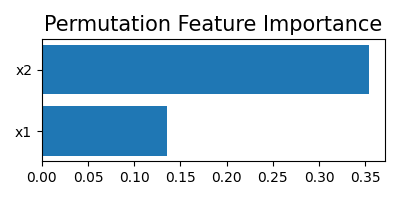

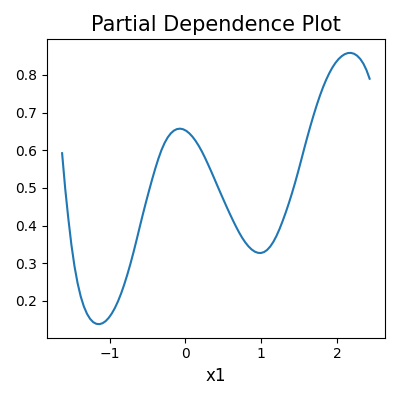

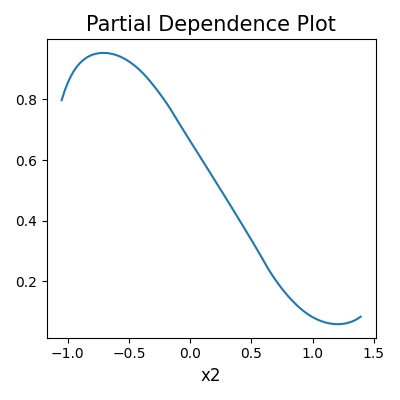

In [7]:
exp.model_explain(model="KAN_OneLayer", show="pfi", figsize=(4,2))
exp.model_explain(model="KAN_OneLayer", show="pdp", uni_feature="x1", figsize=(4,4))
exp.model_explain(model="KAN_OneLayer", show="pdp", uni_feature="x2", figsize=(4,4))

# Two-layer KAN

In [8]:
model2 = KAN(width=[2,2,1], grid=3, k=3)

def train_acc():
    return torch.mean((torch.round(model2(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

def test_acc():
    return torch.mean((torch.round(model2(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())

results = model2.train(dataset, opt="LBFGS", steps=20,
                      metrics=(train_acc, test_acc),
                      in_vars=[r'$x_1$', r'$x_2$'],
                      save_fig=True, img_folder="img_TwoLayer")
results['train_acc'][-1], results['test_acc'][-1]

train loss: 1.56e-01 | test loss: 1.67e-01 | reg: 6.64e+00 : 100%|██| 20/20 [00:48<00:00,  2.43s/it]


(0.968999981880188, 0.9670000076293945)

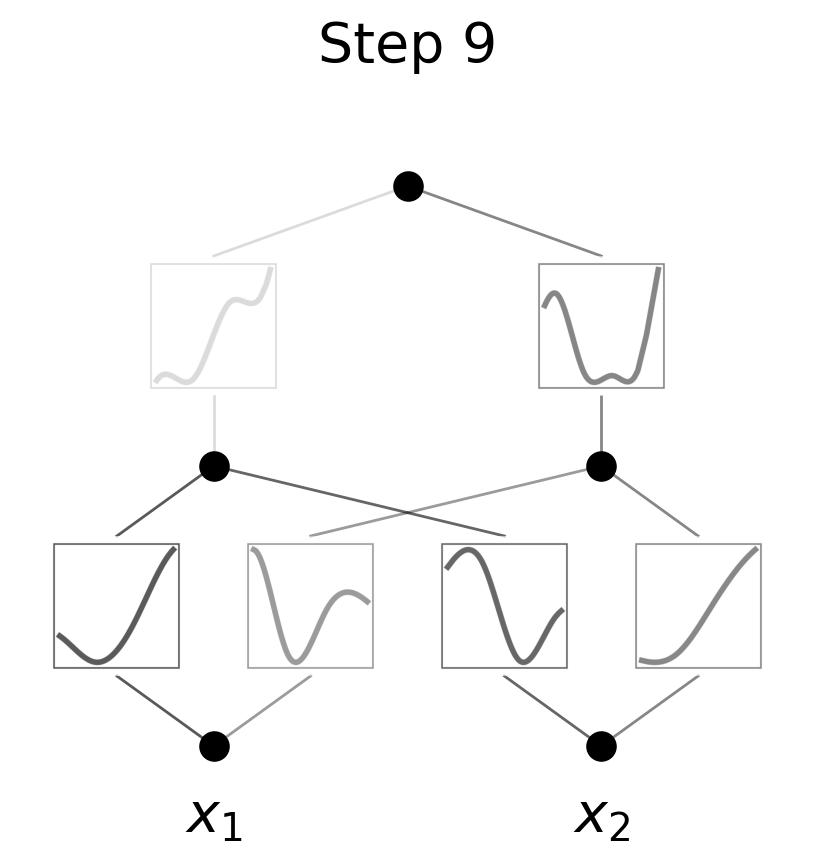

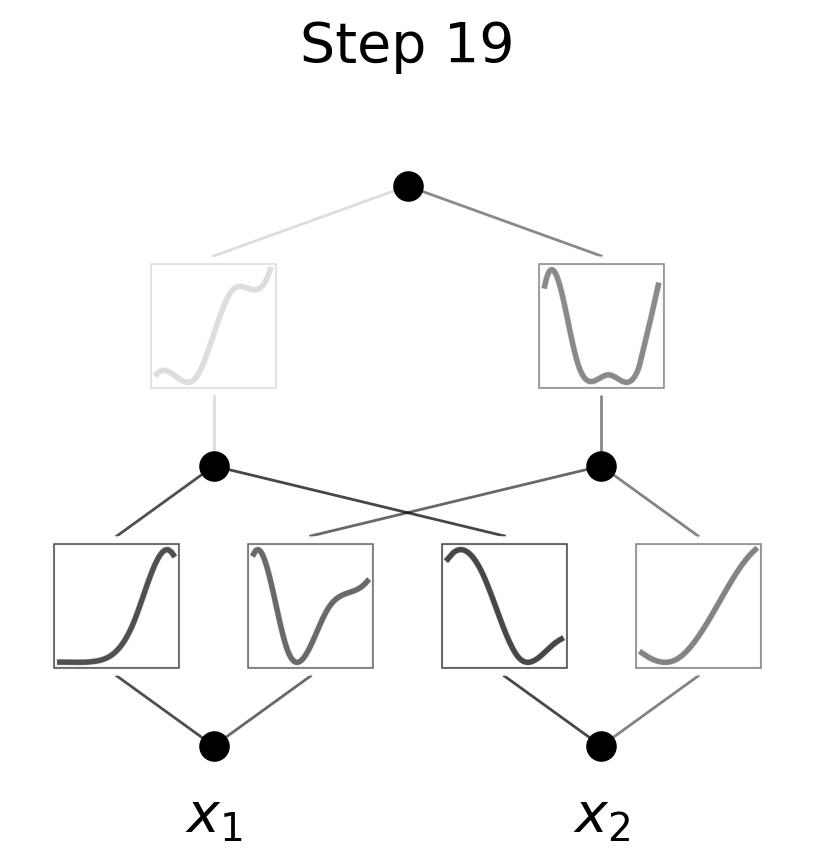

In [9]:
display(Image(filename='/content/img_TwoLayer/9.jpg', height=300))
display(Image(filename='/content/img_TwoLayer/19.jpg', height=300))

In [10]:
def predict_proba_func2(X):
    proba = np.clip(model2(torch.from_numpy(X))[:,0].detach().numpy(), 0, 1)
    return np.vstack([1 - proba, proba]).T

def predict_func2(X):
    proba = np.clip(model2(torch.from_numpy(X))[:,0].detach().numpy(), 0, 1) > 0.5
    return proba

pipeline = exp.make_pipeline(predict_func=predict_func2,
                             predict_proba_func=predict_proba_func2,
                             task_type="classification",
                             train_x=train_input,
                             train_y=train_label,
                             test_x=test_input,
                             test_y=test_label,
                             feature_names=["x1", "x2"],
                             target_name="y")
exp.register(pipeline, "KAN_TwoLayer")

In [11]:
exp.model_diagnose(model="KAN_TwoLayer", show="accuracy_table")

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.9690,0.9961,0.9688,0.0895,0.0233
Test,0.9670,0.9936,0.9667,0.1352,0.0264
Gap,-0.0020,-0.0025,-0.0021,0.0457,0.0031


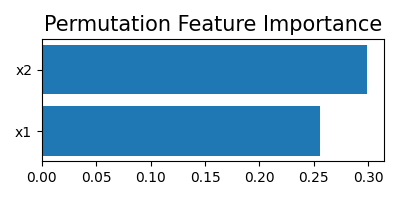

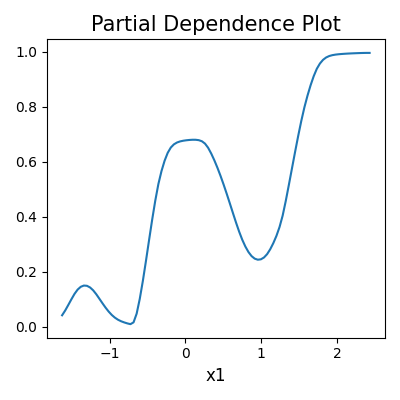

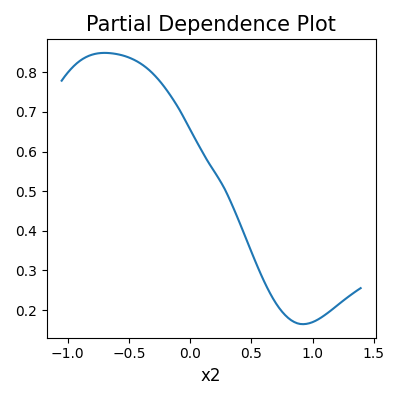

In [12]:
exp.model_explain(model="KAN_TwoLayer", show="pfi", figsize=(4,2))
exp.model_explain(model="KAN_TwoLayer", show="pdp", uni_feature="x1", figsize=(4,4))
exp.model_explain(model="KAN_TwoLayer", show="pdp", uni_feature="x2", figsize=(4,4))

# Model Comparison

In [13]:
## Train GAM (generalized additive model) classifier

from piml.models import GAMClassifier

GAM = GAMClassifier()
GAM.fit(train_input, train_label)
pipeline = exp.make_pipeline(model=GAM,
                             task_type="classification",
                             train_x=train_input,
                             train_y=train_label,
                             test_x=test_input,
                             test_y=test_label,
                             feature_names=["x1", "x2"],
                             target_name="y")
exp.register(pipeline, "GAM")

In [14]:
exp.model_diagnose(model="GAM", show="accuracy_table")

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.9710,0.9966,0.9709,0.0735,0.0203
Test,0.9720,0.9955,0.9716,0.0827,0.0216
Gap,0.0010,-0.0011,0.0007,0.0091,0.0013


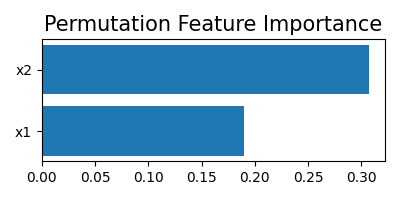

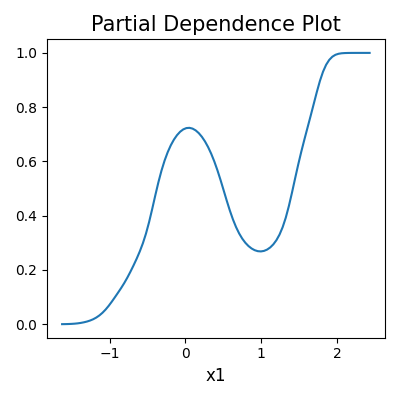

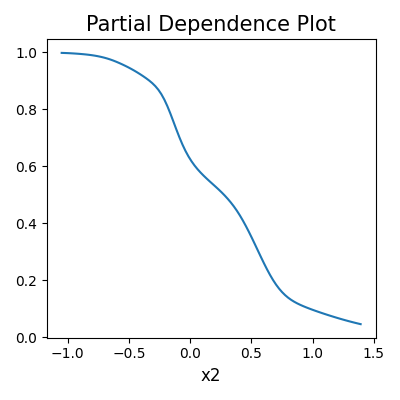

In [15]:
exp.model_explain(model="GAM", show="pfi", figsize=(4,2))
exp.model_explain(model="GAM", show="pdp", uni_feature="x1", figsize=(4,4))
exp.model_explain(model="GAM", show="pdp", uni_feature="x2", figsize=(4,4))

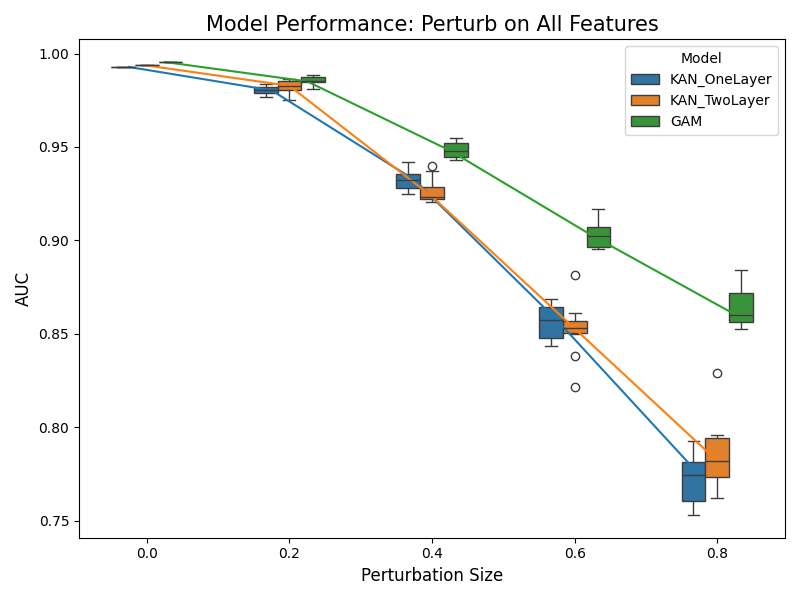

In [16]:
## Compare Model Robustness subject to Covariate Noise Perturbation

exp.model_compare(models=["KAN_OneLayer", "KAN_TwoLayer", "GAM"],
                  show="robustness_perf", metric="AUC", perturb_size=0.2,
                  figsize=(8, 6))